In [58]:
import keras
import soundfile as sf
from tqdm import tqdm
from glob2 import glob
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import models, layers, optimizers, applications
import matplotlib.pyplot as plt
import joblib
import librosa
import pandas as pd
%matplotlib inline
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [187]:
def cnn_model(height, width, color_dim):

    model = Sequential()
    model.add(Convolution2D(32, (3, 3), input_shape=(128, 128, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Convolution2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Convolution2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Convolution2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='Nadam',
                  metrics=['accuracy']
                 )
    return model

In [23]:
def get_emotions_dict():
    emotion_dict = {'happy': [], 'sad': [], 'neutral': [], 'angry':[]}
    for filepath in glob("../data/Audio_Speech_Actors_01-24/*/*.wav"):
        filename = filepath.split("/")[-1]
        emotion = filename.split("-")[2]
        if emotion=="03": 
            emotion_dict["happy"].append(sf.read(filepath)[0])
        elif emotion=="01":
            emotion_dict["neutral"].append(sf.read(filepath)[0])
        elif emotion=="04":
            emotion_dict["sad"].append(sf.read(filepath)[0])
        elif emotion=="05": 
            emotion_dict["angry"].append(sf.read(filepath)[0])
        else:
            pass
    return emotion_dict

emotion_dict = get_emotions_dict()

In [185]:
def get_log_melspectrum(data, sample_rate=48000):
    melspectrum = librosa.feature.melspectrogram(data, sample_rate)
    log_melspec = librosa.power_to_db(melspectrum, ref=np.max)
    scaled_spec = 1.0 - np.divide(log_melspec, -80.0)
    return resize(scaled_spec, (128, 128)).reshape(128, 128, 1)

## y = [happy, neutral, sad, angry]
def prepare_data():
    X, y = [], []
    for filepath in glob("../data/Audio_Speech_Actors_01-24/*/*.wav"):
        filename = filepath.split("/")[-1]
        emotion = filename.split("-")[2]
        try: 
            if emotion=="03":  
                X.append(get_log_melspectrum(sf.read(filepath)[0]))
                y.append([1., 0., 0., 0.])
            elif emotion=="01":
                X.append(get_log_melspectrum(sf.read(filepath)[0]))
                y.append([0., 1., 0., 0.])
            elif emotion=="04":
                X.append(get_log_melspectrum(sf.read(filepath)[0]))
                y.append([0., 0., 1., 0.])
            elif emotion=="05": 
                X.append(get_log_melspectrum(sf.read(filepath)[0]))
                y.append([0., 0., 0., 1.])
            else:
                pass
        except:
            pass
    return X, y

X, y = prepare_data()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    shuffle=True,
                                                    random_state=123)

def train_model(batch_size=32, epochs=100, plot=True):


    model = cnn_model(128, 128, 1)
    filepath = '../models/melspectrogram_with_dropouts0.7_2.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history = model.fit(np.array(X_train), np.array(y_train),
                        validation_data=(np.array(X_test), np.array(y_test)),
                        batch_size=batch_size, nb_epoch=epochs, shuffle=True, callbacks=callbacks_list)
    print("Model melspectrogram_with_dropouts0.7_2.h5 successfully saved")
    if plot:
        plot_training(history)

/Users/karthick/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [146]:
def plot_training(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    validation_loss_values = history_dict['val_loss']
    accuracy_values = history_dict['acc']
    validation_accuracy_values = history_dict['val_acc']
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    ax1.plot(loss_values, 'b', label='Training loss')
    ax1.plot(validation_loss_values, 'r', label='Validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation loss')
    ax2.plot(accuracy_values, 'b', label='Training accuracy')
    ax2.plot(validation_accuracy_values, 'r', label='Validation accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation accuracy')
    plt.show()

/Users/karthick/anaconda3/lib/python3.6/site-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 449 samples, validate on 222 samples
Epoch 1/200
448/449 [============================>.] - ETA: 0s - loss: 1.3998 - acc: 0.2522
Epoch 00001: val_acc improved from -inf to 0.27928, saving model to ../models/melspectrogram_with_dropouts0.7_2.h5
449/449 [==============================] - 15s 33ms/step - loss: 1.3998 - acc: 0.2517 - val_loss: 1.3798 - val_acc: 0.2793
Epoch 2/200
448/449 [============================>.] - ETA: 0s - loss: 1.3633 - acc: 0.2656
Epoch 00002: val_acc did not improve
449/449 [==============================] - 12s 26ms/step - loss: 1.3632 - acc: 0.2650 - val_loss: 1.3720 - val_acc: 0.2793
Epoch 3/200
448/449 [============================>.] - ETA: 0s - loss: 1.3544 - acc: 0.3192
Epoch 00003: val_acc did not improve
449/449 [==============================] - 13s 29ms/step - loss: 1.3559 - acc: 0.3185 - val_loss: 1.3734 - val_acc: 0.2793
Epoch 4/200
448/449 [============================>.] - ETA: 0s - loss: 1.3685 - acc: 0.3058
Epoch 00004: val_acc did not

448/449 [============================>.] - ETA: 0s - loss: 1.0221 - acc: 0.5491
Epoch 00031: val_acc did not improve
449/449 [==============================] - 13s 29ms/step - loss: 1.0220 - acc: 0.5501 - val_loss: 1.6170 - val_acc: 0.3288
Epoch 32/200
448/449 [============================>.] - ETA: 0s - loss: 1.1080 - acc: 0.4978
Epoch 00032: val_acc did not improve
449/449 [==============================] - 11s 24ms/step - loss: 1.1070 - acc: 0.4989 - val_loss: 1.2603 - val_acc: 0.3919
Epoch 33/200
448/449 [============================>.] - ETA: 0s - loss: 1.0807 - acc: 0.5067
Epoch 00033: val_acc improved from 0.40090 to 0.44144, saving model to ../models/melspectrogram_with_dropouts0.7_2.h5
449/449 [==============================] - 11s 25ms/step - loss: 1.0806 - acc: 0.5078 - val_loss: 1.1584 - val_acc: 0.4414
Epoch 34/200
448/449 [============================>.] - ETA: 0s - loss: 1.0389 - acc: 0.5089
Epoch 00034: val_acc did not improve
449/449 [==============================] - 

Epoch 63/200
448/449 [============================>.] - ETA: 0s - loss: 0.9221 - acc: 0.5692
Epoch 00063: val_acc did not improve
449/449 [==============================] - 11s 24ms/step - loss: 0.9208 - acc: 0.5702 - val_loss: 1.3116 - val_acc: 0.3964
Epoch 64/200
448/449 [============================>.] - ETA: 0s - loss: 0.9560 - acc: 0.6004
Epoch 00064: val_acc did not improve
449/449 [==============================] - 11s 24ms/step - loss: 0.9549 - acc: 0.6013 - val_loss: 1.6884 - val_acc: 0.3243
Epoch 65/200
448/449 [============================>.] - ETA: 0s - loss: 0.8444 - acc: 0.6272
Epoch 00065: val_acc did not improve
449/449 [==============================] - 11s 24ms/step - loss: 0.8425 - acc: 0.6281 - val_loss: 1.3446 - val_acc: 0.4279
Epoch 66/200
448/449 [============================>.] - ETA: 0s - loss: 0.8133 - acc: 0.6362
Epoch 00066: val_acc did not improve
449/449 [==============================] - 11s 24ms/step - loss: 0.8138 - acc: 0.6370 - val_loss: 1.3575 - val_

448/449 [============================>.] - ETA: 0s - loss: 0.9570 - acc: 0.5804
Epoch 00095: val_acc did not improve
449/449 [==============================] - 11s 24ms/step - loss: 0.9548 - acc: 0.5813 - val_loss: 1.2276 - val_acc: 0.3694
Epoch 96/200
448/449 [============================>.] - ETA: 0s - loss: 0.8945 - acc: 0.5826
Epoch 00096: val_acc did not improve
449/449 [==============================] - 11s 24ms/step - loss: 0.8934 - acc: 0.5835 - val_loss: 1.3529 - val_acc: 0.4054
Epoch 97/200
448/449 [============================>.] - ETA: 0s - loss: 0.8380 - acc: 0.6562
Epoch 00097: val_acc did not improve
449/449 [==============================] - 11s 24ms/step - loss: 0.8429 - acc: 0.6548 - val_loss: 1.2863 - val_acc: 0.4009
Epoch 98/200
448/449 [============================>.] - ETA: 0s - loss: 1.0623 - acc: 0.5737
Epoch 00098: val_acc did not improve
449/449 [==============================] - 11s 24ms/step - loss: 1.0603 - acc: 0.5746 - val_loss: 1.2452 - val_acc: 0.4144
E

448/449 [============================>.] - ETA: 0s - loss: 0.6551 - acc: 0.7210
Epoch 00127: val_acc did not improve
449/449 [==============================] - 14s 31ms/step - loss: 0.6536 - acc: 0.7216 - val_loss: 1.6291 - val_acc: 0.3784
Epoch 128/200
448/449 [============================>.] - ETA: 0s - loss: 0.6974 - acc: 0.7031
Epoch 00128: val_acc did not improve
449/449 [==============================] - 12s 28ms/step - loss: 0.6976 - acc: 0.7038 - val_loss: 1.4662 - val_acc: 0.3874
Epoch 129/200
448/449 [============================>.] - ETA: 0s - loss: 0.6815 - acc: 0.7188
Epoch 00129: val_acc did not improve
449/449 [==============================] - 11s 25ms/step - loss: 0.6851 - acc: 0.7171 - val_loss: 1.8917 - val_acc: 0.3468
Epoch 130/200
448/449 [============================>.] - ETA: 0s - loss: 0.7989 - acc: 0.6451
Epoch 00130: val_acc did not improve
449/449 [==============================] - 12s 27ms/step - loss: 0.7999 - acc: 0.6459 - val_loss: 1.4590 - val_acc: 0.409

448/449 [============================>.] - ETA: 0s - loss: 0.6205 - acc: 0.7366
Epoch 00159: val_acc did not improve
449/449 [==============================] - 11s 25ms/step - loss: 0.6195 - acc: 0.7372 - val_loss: 1.5921 - val_acc: 0.4459
Epoch 160/200
448/449 [============================>.] - ETA: 0s - loss: 0.6274 - acc: 0.7411
Epoch 00160: val_acc did not improve
449/449 [==============================] - 11s 25ms/step - loss: 0.6276 - acc: 0.7416 - val_loss: 1.8772 - val_acc: 0.3874
Epoch 161/200
448/449 [============================>.] - ETA: 0s - loss: 0.5914 - acc: 0.7679
Epoch 00161: val_acc did not improve
449/449 [==============================] - 11s 26ms/step - loss: 0.5916 - acc: 0.7684 - val_loss: 2.0689 - val_acc: 0.4054
Epoch 162/200
448/449 [============================>.] - ETA: 0s - loss: 0.6530 - acc: 0.7098
Epoch 00162: val_acc did not improve
449/449 [==============================] - 13s 28ms/step - loss: 0.6561 - acc: 0.7082 - val_loss: 1.5687 - val_acc: 0.382

448/449 [============================>.] - ETA: 0s - loss: 0.6147 - acc: 0.7411
Epoch 00191: val_acc did not improve
449/449 [==============================] - 11s 25ms/step - loss: 0.6146 - acc: 0.7416 - val_loss: 1.8443 - val_acc: 0.3919
Epoch 192/200
448/449 [============================>.] - ETA: 0s - loss: 0.5237 - acc: 0.7946
Epoch 00192: val_acc did not improve
449/449 [==============================] - 12s 26ms/step - loss: 0.5225 - acc: 0.7951 - val_loss: 1.7292 - val_acc: 0.3829
Epoch 193/200
448/449 [============================>.] - ETA: 0s - loss: 0.5429 - acc: 0.7812
Epoch 00193: val_acc did not improve
449/449 [==============================] - 11s 25ms/step - loss: 0.5417 - acc: 0.7817 - val_loss: 1.8295 - val_acc: 0.3784
Epoch 194/200
448/449 [============================>.] - ETA: 0s - loss: 0.5886 - acc: 0.7857
Epoch 00194: val_acc did not improve
449/449 [==============================] - 11s 25ms/step - loss: 0.5893 - acc: 0.7862 - val_loss: 1.6849 - val_acc: 0.391

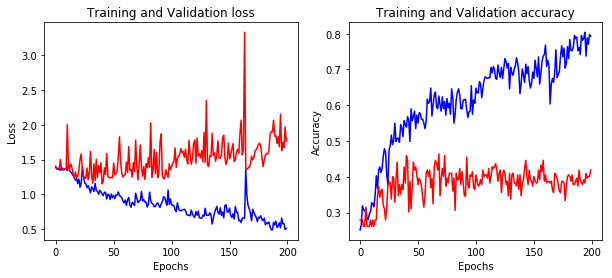

In [188]:
train_model(batch_size=32, epochs=200)

/Users/karthick/anaconda3/lib/python3.6/site-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 449 samples, validate on 222 samples
Epoch 1/100
448/449 [============================>.] - ETA: 0s - loss: 1.7139 - acc: 0.3013
Epoch 00001: val_acc improved from -inf to 0.28829, saving model to ../models/melspectrogram_with_dropouts.h5
449/449 [==============================] - 12s 26ms/step - loss: 1.7134 - acc: 0.3007 - val_loss: 1.3817 - val_acc: 0.2883
Epoch 2/100
448/449 [============================>.] - ETA: 0s - loss: 1.3343 - acc: 0.3549
Epoch 00002: val_acc improved from 0.28829 to 0.31532, saving model to ../models/melspectrogram_with_dropouts.h5
449/449 [==============================] - 10s 22ms/step - loss: 1.3340 - acc: 0.3563 - val_loss: 1.3845 - val_acc: 0.3153
Epoch 3/100
448/449 [============================>.] - ETA: 0s - loss: 1.3117 - acc: 0.3683
Epoch 00003: val_acc improved from 0.31532 to 0.31982, saving model to ../models/melspectrogram_with_dropouts.h5
449/449 [==============================] - 10s 23ms/step - loss: 1.3118 - acc: 0.3675 - val_loss

448/449 [============================>.] - ETA: 0s - loss: 0.8770 - acc: 0.5915
Epoch 00030: val_acc did not improve
449/449 [==============================] - 10s 22ms/step - loss: 0.8779 - acc: 0.5902 - val_loss: 1.0774 - val_acc: 0.6081
Epoch 31/100
448/449 [============================>.] - ETA: 0s - loss: 0.8307 - acc: 0.6562
Epoch 00031: val_acc did not improve
449/449 [==============================] - 12s 27ms/step - loss: 0.8341 - acc: 0.6548 - val_loss: 1.0668 - val_acc: 0.5450
Epoch 32/100
448/449 [============================>.] - ETA: 0s - loss: 0.9229 - acc: 0.5982
Epoch 00032: val_acc did not improve
449/449 [==============================] - 10s 22ms/step - loss: 0.9237 - acc: 0.5969 - val_loss: 1.1382 - val_acc: 0.5766
Epoch 33/100
448/449 [============================>.] - ETA: 0s - loss: 0.8327 - acc: 0.6518
Epoch 00033: val_acc did not improve
449/449 [==============================] - 9s 20ms/step - loss: 0.8318 - acc: 0.6526 - val_loss: 1.0882 - val_acc: 0.5180
Ep

Epoch 62/100
448/449 [============================>.] - ETA: 0s - loss: 0.6701 - acc: 0.7277
Epoch 00062: val_acc improved from 0.63514 to 0.64414, saving model to ../models/melspectrogram_with_dropouts.h5
449/449 [==============================] - 9s 21ms/step - loss: 0.6690 - acc: 0.7283 - val_loss: 0.9876 - val_acc: 0.6441
Epoch 63/100
448/449 [============================>.] - ETA: 0s - loss: 0.6591 - acc: 0.7277
Epoch 00063: val_acc did not improve
449/449 [==============================] - 9s 21ms/step - loss: 0.6579 - acc: 0.7283 - val_loss: 0.9911 - val_acc: 0.6216
Epoch 64/100
448/449 [============================>.] - ETA: 0s - loss: 0.6460 - acc: 0.7299
Epoch 00064: val_acc did not improve
449/449 [==============================] - 9s 20ms/step - loss: 0.6478 - acc: 0.7283 - val_loss: 1.0065 - val_acc: 0.6216
Epoch 65/100
448/449 [============================>.] - ETA: 0s - loss: 0.6545 - acc: 0.7165
Epoch 00065: val_acc did not improve
449/449 [=============================

Epoch 93/100
448/449 [============================>.] - ETA: 0s - loss: 0.5218 - acc: 0.7701
Epoch 00093: val_acc did not improve
449/449 [==============================] - 11s 24ms/step - loss: 0.5228 - acc: 0.7706 - val_loss: 0.9664 - val_acc: 0.6622
Epoch 94/100
448/449 [============================>.] - ETA: 0s - loss: 0.5194 - acc: 0.8058
Epoch 00094: val_acc improved from 0.67568 to 0.69369, saving model to ../models/melspectrogram_with_dropouts.h5
449/449 [==============================] - 10s 22ms/step - loss: 0.5213 - acc: 0.8040 - val_loss: 0.9214 - val_acc: 0.6937
Epoch 95/100
448/449 [============================>.] - ETA: 0s - loss: 0.5097 - acc: 0.7835
Epoch 00095: val_acc did not improve
449/449 [==============================] - 9s 20ms/step - loss: 0.5115 - acc: 0.7817 - val_loss: 0.9573 - val_acc: 0.6216
Epoch 96/100
448/449 [============================>.] - ETA: 0s - loss: 0.5396 - acc: 0.7790
Epoch 00096: val_acc did not improve
449/449 [===========================

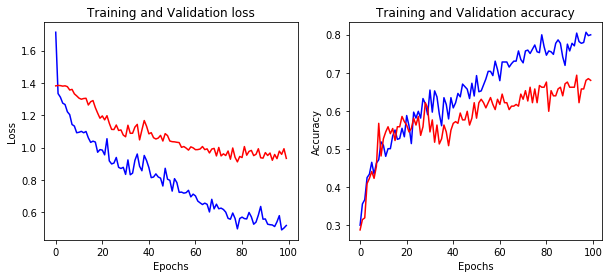

In [103]:
train_model(batch_size=32, epochs=100)

In [156]:
def get_tonnetz(peak, sr=48000):
    peak=librosa.effects.harmonic(peak)
    tonnetz = librosa.feature.tonnetz(y=peak, sr=sr)
    return resize(tonnetz, (128, 128)).reshape(128, 128, 1)





## y = [happy, neutral, sad, angry]
def prepare_data():
    X, y = [], []
    for filepath in glob("../data/Audio_Speech_Actors_01-24/*/*.wav"):
        filename = filepath.split("/")[-1]
        emotion = filename.split("-")[2]
        try: 
            if emotion=="03":  
                X.append(get_tonnetz(sf.read(filepath)[0]))
                y.append([1, 0, 0, 0])
            elif emotion=="01":
                X.append(get_tonnetz(sf.read(filepath)[0]))
                y.append([0, 1, 0, 0])
            elif emotion=="04":
                X.append(get_tonnetz(sf.read(filepath)[0]))
                y.append([0, 0, 1, 0])
            elif emotion=="05": 
                X.append(get_tonnetz(sf.read(filepath)[0]))
                y.append([0, 0, 0, 1])
            else:
                pass
        except:
            pass
    return X, y

X, y = prepare_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=123)


def train_model(batch_size=32, epochs=100, plot=True):


    model = cnn_model(128, 128, 1)
    filepath = '../models/tonnetz_with_dropouts.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history = model.fit(np.array(X_train), np.array(y_train),
                        validation_data=(np.array(X_test), np.array(y_test)),
                        batch_size=batch_size, nb_epoch=epochs, shuffle=True, callbacks=callbacks_list)
    print("Model tonnetz_with_dropouts.h5 successfully saved")
    if plot:
        plot_training(history)

/Users/karthick/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1640: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(dtype, float):
/Users/karthick/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):
/Users/karthick/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):
/Users/karthick/anacond

/Users/karthick/anaconda3/lib/python3.6/site-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 449 samples, validate on 222 samples
Epoch 1/100
448/449 [============================>.] - ETA: 0s - loss: 1.3725 - acc: 0.2812
Epoch 00001: val_acc improved from -inf to 0.31532, saving model to ../models/tonnetz_with_dropouts.h5
449/449 [==============================] - 14s 30ms/step - loss: 1.3722 - acc: 0.2806 - val_loss: 1.3622 - val_acc: 0.3153
Epoch 2/100
448/449 [============================>.] - ETA: 0s - loss: 1.3843 - acc: 0.2746
Epoch 00002: val_acc improved from 0.31532 to 0.32432, saving model to ../models/tonnetz_with_dropouts.h5
449/449 [==============================] - 11s 25ms/step - loss: 1.3845 - acc: 0.2739 - val_loss: 1.3777 - val_acc: 0.3243
Epoch 3/100
448/449 [============================>.] - ETA: 0s - loss: 1.3628 - acc: 0.2991
Epoch 00003: val_acc did not improve
449/449 [==============================] - 11s 25ms/step - loss: 1.3625 - acc: 0.3007 - val_loss: 1.3766 - val_acc: 0.2613
Epoch 4/100
448/449 [============================>.] - ETA: 0s 

Epoch 32/100
448/449 [============================>.] - ETA: 0s - loss: 1.2229 - acc: 0.4487
Epoch 00032: val_acc did not improve
449/449 [==============================] - 11s 25ms/step - loss: 1.2210 - acc: 0.4499 - val_loss: 1.3489 - val_acc: 0.3829
Epoch 33/100
448/449 [============================>.] - ETA: 0s - loss: 1.1651 - acc: 0.5156
Epoch 00033: val_acc did not improve
449/449 [==============================] - 12s 26ms/step - loss: 1.1652 - acc: 0.5145 - val_loss: 1.2999 - val_acc: 0.3919
Epoch 34/100
448/449 [============================>.] - ETA: 0s - loss: 1.1567 - acc: 0.4821
Epoch 00034: val_acc did not improve
449/449 [==============================] - 12s 26ms/step - loss: 1.1568 - acc: 0.4811 - val_loss: 1.3812 - val_acc: 0.3694
Epoch 35/100
448/449 [============================>.] - ETA: 0s - loss: 1.1832 - acc: 0.4643
Epoch 00035: val_acc did not improve
449/449 [==============================] - 11s 25ms/step - loss: 1.1833 - acc: 0.4633 - val_loss: 1.3256 - val_

Epoch 64/100
448/449 [============================>.] - ETA: 0s - loss: 1.0031 - acc: 0.5625
Epoch 00064: val_acc did not improve
449/449 [==============================] - 11s 26ms/step - loss: 1.0026 - acc: 0.5635 - val_loss: 1.2523 - val_acc: 0.3829
Epoch 65/100
448/449 [============================>.] - ETA: 0s - loss: 0.9733 - acc: 0.5670
Epoch 00065: val_acc improved from 0.41892 to 0.43694, saving model to ../models/tonnetz_with_dropouts.h5
449/449 [==============================] - 12s 26ms/step - loss: 0.9727 - acc: 0.5679 - val_loss: 1.2676 - val_acc: 0.4369
Epoch 66/100
448/449 [============================>.] - ETA: 0s - loss: 0.9637 - acc: 0.5625
Epoch 00066: val_acc improved from 0.43694 to 0.45045, saving model to ../models/tonnetz_with_dropouts.h5
449/449 [==============================] - 13s 28ms/step - loss: 0.9641 - acc: 0.5612 - val_loss: 1.2590 - val_acc: 0.4505
Epoch 67/100
448/449 [============================>.] - ETA: 0s - loss: 0.9258 - acc: 0.5804
Epoch 0006

Epoch 96/100
448/449 [============================>.] - ETA: 0s - loss: 0.8583 - acc: 0.6138
Epoch 00096: val_acc did not improve
449/449 [==============================] - 11s 25ms/step - loss: 0.8564 - acc: 0.6147 - val_loss: 1.3904 - val_acc: 0.4054
Epoch 97/100
448/449 [============================>.] - ETA: 0s - loss: 0.7888 - acc: 0.6607
Epoch 00097: val_acc did not improve
449/449 [==============================] - 11s 24ms/step - loss: 0.7884 - acc: 0.6615 - val_loss: 1.3166 - val_acc: 0.4054
Epoch 98/100
448/449 [============================>.] - ETA: 0s - loss: 0.7245 - acc: 0.7165
Epoch 00098: val_acc did not improve
449/449 [==============================] - 11s 24ms/step - loss: 0.7233 - acc: 0.7171 - val_loss: 1.3693 - val_acc: 0.4009
Epoch 99/100
448/449 [============================>.] - ETA: 0s - loss: 0.7408 - acc: 0.7121
Epoch 00099: val_acc did not improve
449/449 [==============================] - 11s 26ms/step - loss: 0.7446 - acc: 0.7105 - val_loss: 1.4032 - val_

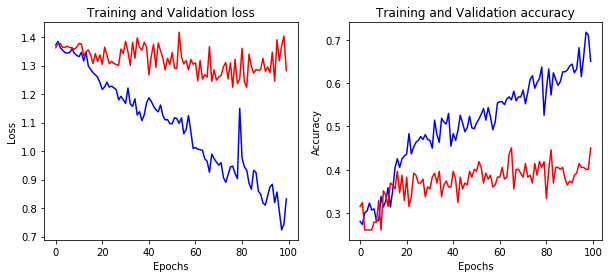

In [157]:
train_model(64, 100)

In [97]:
def get_spectral_contrast(peak, sr=48000):
    S = np.abs(librosa.stft(peak))
    contrast = np.divide(librosa.feature.spectral_contrast(S=S, sr=sr), 40.0)
    return resize(contrast, (128, 128)).reshape(128, 128, 1)

## y = [happy, neutral, sad, angry]
def prepare_data():
    X, y = [], []
    for filepath in glob("../data/Audio_Speech_Actors_01-24/*/*.wav"):
        filename = filepath.split("/")[-1]
        emotion = filename.split("-")[2]
        try: 
            if emotion=="03":  
                X.append(get_spectral_contrast(sf.read(filepath)[0]))
                y.append([1, 0, 0, 0])
            elif emotion=="01":
                X.append(get_spectral_contrast(sf.read(filepath)[0]))
                y.append([0, 1, 0, 0])
            elif emotion=="04":
                X.append(get_spectral_contrast(sf.read(filepath)[0]))
                y.append([0, 0, 1, 0])
            elif emotion=="05": 
                X.append(get_spectral_contrast(sf.read(filepath)[0]))
                y.append([0, 0, 0, 1])
            else:
                pass
        except:
            pass
    return X, y

X, y = prepare_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.30, 
                                                    random_state=123, 
                                                    shuffle=True
                                                   )


def train_model(batch_size=32, epochs=100, plot=True):


    model = cnn_model(128, 128, 1)
    filepath = '../models/spectral_contrast_with_dropouts.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history = model.fit(np.array(X_train), np.array(y_train),
                        validation_data=(np.array(X_test), np.array(y_test)),
                        batch_size=batch_size, nb_epoch=epochs, shuffle=True, callbacks=callbacks_list)
    print("Model spectral_contrast_with_dropouts.h5 successfully saved")
    if plot:
        plot_training(history)

/Users/karthick/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


/Users/karthick/anaconda3/lib/python3.6/site-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 469 samples, validate on 202 samples
Epoch 1/100
448/469 [===========================>..] - ETA: 0s - loss: 1.5406 - acc: 0.2746
Epoch 00001: val_acc improved from -inf to 0.26733, saving model to ../models/spectral_contrast_with_dropouts.h5
469/469 [==============================] - 11s 23ms/step - loss: 1.5335 - acc: 0.2793 - val_loss: 1.3868 - val_acc: 0.2673
Epoch 2/100
448/469 [===========================>..] - ETA: 0s - loss: 1.3778 - acc: 0.2835
Epoch 00002: val_acc did not improve
469/469 [==============================] - 10s 20ms/step - loss: 1.3777 - acc: 0.2772 - val_loss: 1.3848 - val_acc: 0.2673
Epoch 3/100
448/469 [===========================>..] - ETA: 0s - loss: 1.3502 - acc: 0.2902
Epoch 00003: val_acc did not improve
469/469 [==============================] - 10s 21ms/step - loss: 1.3489 - acc: 0.2964 - val_loss: 1.3825 - val_acc: 0.2673
Epoch 4/100
448/469 [===========================>..] - ETA: 0s - loss: 1.3479 - acc: 0.3013
Epoch 00004: val_acc did not i

448/469 [===========================>..] - ETA: 0s - loss: 0.7720 - acc: 0.6786
Epoch 00029: val_acc did not improve
469/469 [==============================] - 9s 20ms/step - loss: 0.7789 - acc: 0.6716 - val_loss: 0.9954 - val_acc: 0.5297
Epoch 30/100
448/469 [===========================>..] - ETA: 0s - loss: 0.7865 - acc: 0.6317
Epoch 00030: val_acc did not improve
469/469 [==============================] - 9s 20ms/step - loss: 0.7818 - acc: 0.6333 - val_loss: 1.0209 - val_acc: 0.5149
Epoch 31/100
448/469 [===========================>..] - ETA: 0s - loss: 0.7260 - acc: 0.7054
Epoch 00031: val_acc did not improve
469/469 [==============================] - 9s 20ms/step - loss: 0.7447 - acc: 0.6994 - val_loss: 1.0447 - val_acc: 0.5347
Epoch 32/100
448/469 [===========================>..] - ETA: 0s - loss: 0.7482 - acc: 0.7098
Epoch 00032: val_acc did not improve
469/469 [==============================] - 10s 21ms/step - loss: 0.7442 - acc: 0.7122 - val_loss: 1.0287 - val_acc: 0.5198
Epoc

Epoch 60/100
448/469 [===========================>..] - ETA: 0s - loss: 0.4227 - acc: 0.8259
Epoch 00060: val_acc did not improve
469/469 [==============================] - 9s 20ms/step - loss: 0.4294 - acc: 0.8273 - val_loss: 1.0904 - val_acc: 0.5842
Epoch 61/100
448/469 [===========================>..] - ETA: 0s - loss: 0.4791 - acc: 0.8036
Epoch 00061: val_acc did not improve
469/469 [==============================] - 10s 21ms/step - loss: 0.4727 - acc: 0.8081 - val_loss: 1.0468 - val_acc: 0.5842
Epoch 62/100
448/469 [===========================>..] - ETA: 0s - loss: 0.4183 - acc: 0.8103
Epoch 00062: val_acc did not improve
469/469 [==============================] - 9s 19ms/step - loss: 0.4169 - acc: 0.8124 - val_loss: 1.0545 - val_acc: 0.5743
Epoch 63/100
448/469 [===========================>..] - ETA: 0s - loss: 0.3898 - acc: 0.8594
Epoch 00063: val_acc did not improve
469/469 [==============================] - 9s 19ms/step - loss: 0.3887 - acc: 0.8571 - val_loss: 1.1005 - val_acc

448/469 [===========================>..] - ETA: 0s - loss: 0.2531 - acc: 0.9062
Epoch 00092: val_acc did not improve
469/469 [==============================] - 9s 20ms/step - loss: 0.2688 - acc: 0.8998 - val_loss: 1.2008 - val_acc: 0.5743
Epoch 93/100
448/469 [===========================>..] - ETA: 0s - loss: 0.2590 - acc: 0.8884
Epoch 00093: val_acc did not improve
469/469 [==============================] - 9s 20ms/step - loss: 0.2512 - acc: 0.8934 - val_loss: 1.2233 - val_acc: 0.5644
Epoch 94/100
448/469 [===========================>..] - ETA: 0s - loss: 0.2692 - acc: 0.8973
Epoch 00094: val_acc did not improve
469/469 [==============================] - 9s 20ms/step - loss: 0.2695 - acc: 0.8955 - val_loss: 1.2738 - val_acc: 0.5743
Epoch 95/100
448/469 [===========================>..] - ETA: 0s - loss: 0.2370 - acc: 0.9152
Epoch 00095: val_acc did not improve
469/469 [==============================] - 9s 20ms/step - loss: 0.2410 - acc: 0.9147 - val_loss: 1.3041 - val_acc: 0.5545
Epoch

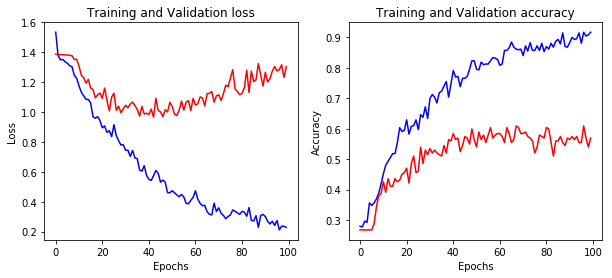

In [98]:
train_model()

In [96]:
np.max(get_spectral_contrast(sf.read(filepath)[0])), np.min(get_spectral_contrast(sf.read(filepath)[0]))

/Users/karthick/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(0.9947332565260437, 0.054345107204910634)

In [105]:
def get_log_melspectrum(data, sample_rate=48000):
    melspectrum = librosa.feature.melspectrogram(data, sample_rate)
    log_melspec = librosa.power_to_db(melspectrum, ref=np.max)
    scaled_spec = 1.0 - np.divide(log_melspec, -80.0)
    return resize(scaled_spec, (128, 128)).reshape(128, 128, 1)

In [108]:

## y = [3: happy, 1: neutral, 4: sad, 5:angry]
filepath = "../data/Audio_Speech_Actors_01-24/Actor_23/03-01-05-01-01-01-23.wav" 
model.predict_proba(get_log_melspectrum(sf.read(filepath)[0]).reshape(1, 128, 128, 1))

/Users/karthick/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


array([[0.2562822 , 0.25292394, 0.24464056, 0.24615325]], dtype=float32)

In [155]:
## y = [3: happy, 1: neutral, 4: sad, 5:angry]
number = 56
print(np.argmax(y[number]))
print(model.predict_proba(X[number].reshape(1, 128, 128, 1)))

1
[[0.25383857 0.2565221  0.2442781  0.24536131]]


In [111]:
y[10], X[10]

([1, 0, 0, 0], array([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        ...,
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]]))

In [148]:
np.max(X[0])

0.995099293988727

In [176]:
def get_mfccs(data, sample_rate=48000):
    mfccs = librosa.feature.mfcc(data, sample_rate, n_mfcc=128)
    scaled_mfccs = np.interp(mfccs, (mfccs.min(), mfccs.max()), (0, 1))
    return resize(scaled_mfccs, (128, 128)).reshape(128, 128, 1)


## y = [happy, neutral, sad, angry]
def prepare_data():
    X, y = [], []
    for filepath in glob("../data/Audio_Speech_Actors_01-24/*/*.wav"):
        filename = filepath.split("/")[-1]
        emotion = filename.split("-")[2]
        try: 
            if emotion=="03":  
                X.append(get_mfccs(sf.read(filepath)[0]))
                y.append([1, 0, 0, 0])
            elif emotion=="01":
                X.append(get_mfccs(sf.read(filepath)[0]))
                y.append([0, 1, 0, 0])
            elif emotion=="04":
                X.append(get_mfccs(sf.read(filepath)[0]))
                y.append([0, 0, 1, 0])
            elif emotion=="05": 
                X.append(get_mfccs(sf.read(filepath)[0]))
                y.append([0, 0, 0, 1])
            else:
                pass
        except:
            pass
    return X, y

X, y = prepare_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    shuffle=True,
                                                    random_state=123)


def train_model(batch_size=32, epochs=100, plot=True):


    model = cnn_model(128, 128, 1)
    filepath = '../models/tonnetz_with_dropouts.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history = model.fit(np.array(X_train), np.array(y_train),
                        validation_data=(np.array(X_test), np.array(y_test)),
                        batch_size=batch_size, nb_epoch=epochs, shuffle=True, callbacks=callbacks_list)
    print("Model tonnetz_with_dropouts.h5 successfully saved")
    if plot:
        plot_training(history)

/Users/karthick/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [177]:
train_model(batch_size=32, epochs=300)

/Users/karthick/anaconda3/lib/python3.6/site-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 449 samples, validate on 222 samples
Epoch 1/300
448/449 [============================>.] - ETA: 0s - loss: 1.4256 - acc: 0.2746
Epoch 00001: val_acc improved from -inf to 0.26126, saving model to ../models/tonnetz_with_dropouts.h5
449/449 [==============================] - 14s 31ms/step - loss: 1.4256 - acc: 0.2739 - val_loss: 1.3820 - val_acc: 0.2613
Epoch 2/300
448/449 [============================>.] - ETA: 0s - loss: 1.3688 - acc: 0.2790
Epoch 00002: val_acc improved from 0.26126 to 0.27928, saving model to ../models/tonnetz_with_dropouts.h5
449/449 [==============================] - 11s 24ms/step - loss: 1.3689 - acc: 0.2784 - val_loss: 1.3811 - val_acc: 0.2793
Epoch 3/300
448/449 [============================>.] - ETA: 0s - loss: 1.3642 - acc: 0.2790
Epoch 00003: val_acc improved from 0.27928 to 0.31532, saving model to ../models/tonnetz_with_dropouts.h5
449/449 [==============================] - 11s 24ms/step - loss: 1.3638 - acc: 0.2806 - val_loss: 1.3774 - val_acc: 0

Epoch 33/300
448/449 [============================>.] - ETA: 0s - loss: 1.3520 - acc: 0.2812
Epoch 00033: val_acc did not improve
449/449 [==============================] - 12s 27ms/step - loss: 1.3517 - acc: 0.2829 - val_loss: 1.3536 - val_acc: 0.2793
Epoch 34/300
448/449 [============================>.] - ETA: 0s - loss: 1.3556 - acc: 0.3147
Epoch 00034: val_acc did not improve
449/449 [==============================] - 11s 25ms/step - loss: 1.3554 - acc: 0.3140 - val_loss: 1.3533 - val_acc: 0.2613
Epoch 35/300
448/449 [============================>.] - ETA: 0s - loss: 1.3558 - acc: 0.2902
Epoch 00035: val_acc did not improve
449/449 [==============================] - 12s 28ms/step - loss: 1.3558 - acc: 0.2895 - val_loss: 1.3548 - val_acc: 0.2613
Epoch 36/300
448/449 [============================>.] - ETA: 0s - loss: 1.3584 - acc: 0.2969
Epoch 00036: val_acc did not improve
449/449 [==============================] - 12s 28ms/step - loss: 1.3584 - acc: 0.2962 - val_loss: 1.3546 - val_

Epoch 66/300
448/449 [============================>.] - ETA: 0s - loss: 1.3561 - acc: 0.2500
Epoch 00066: val_acc did not improve
449/449 [==============================] - 11s 24ms/step - loss: 1.3560 - acc: 0.2494 - val_loss: 1.3536 - val_acc: 0.2613
Epoch 67/300
448/449 [============================>.] - ETA: 0s - loss: 1.3511 - acc: 0.2946
Epoch 00067: val_acc did not improve
449/449 [==============================] - 11s 25ms/step - loss: 1.3509 - acc: 0.2962 - val_loss: 1.3530 - val_acc: 0.2613
Epoch 68/300
448/449 [============================>.] - ETA: 0s - loss: 1.3517 - acc: 0.2902
Epoch 00068: val_acc did not improve
449/449 [==============================] - 12s 27ms/step - loss: 1.3531 - acc: 0.2895 - val_loss: 1.3534 - val_acc: 0.2793
Epoch 69/300
448/449 [============================>.] - ETA: 0s - loss: 1.3544 - acc: 0.3013
Epoch 00069: val_acc did not improve
449/449 [==============================] - 11s 25ms/step - loss: 1.3543 - acc: 0.3007 - val_loss: 1.3564 - val_

KeyboardInterrupt: 

In [170]:
np.max(get_mfccs(sf.read(filepath)[0])), np.min(get_mfccs(sf.read(filepath)[0]))

(1.0, 0.0)

In [ ]:
np.interp(a, (a.min(), a.max()), (-1, +1))

In [190]:
a = np.array([1, 2, 3, 4], dtype=np.uint8)

In [191]:
a.dtype

dtype('uint8')

In [192]:
a.astype(np.float64)

array([1., 2., 3., 4.])

In [202]:

import soundfile as sf
filepath = "/Users/karthick/Downloads/audio2018-05-27 10_41_55.ogg"

In [205]:
np.fromfile(filepath, dtype=int)

array([-9113523542521068262, -9083124924210003455, -8898477309423304188,
         324689367520142711,  7458052345511904578,                 -255,
       -5631985970662782699,  4865717516699307907, -8772634506001681816,
        6059141869369190467,   108605075714173870, -3119659906659531405,
        4721608604665488968, -7808569594342256801,  7233173838382854223,
            206158430208257,  5153443494588579840,  7233345607740457019,
         -71646693390610303, -9086012248219975681, -9223371481860168960,
        3854798705517560827, -5770144577533575241, -1447387844725276221,
         969052259525859320,  4925342483675329363, -7911134796320524301,
        4721034009011690237, -4468059203144116134,  3481577020649645964,
       -8232242543771517853, -8534012117176684106, -7868670065741619351,
       -1180938811449433738, -7333015987691688583, -8665909889894092901,
       -5885912825343170381,  4908345196675205161,  6007410015198515143,
        6901442020671817729,  9011106621055571450, 

In [216]:
np.fromfile(filepath, dtype=np.uint16)

array([17690, 41951, 17055, ..., 17718, 15665, 55008], dtype=uint16)

In [213]:
np.max(np.fromfile(filepath, dtype=np.float16))

nan

In [214]:
np.fromfile(filepath, dtype=np.float32)

array([-2.4206974e-17, -4.9319423e-38, -9.0828181e-38, ...,
       -1.6214839e-19,  1.5276407e+32,  4.3278895e-02], dtype=float32)

In [223]:
np.fromfile("../data/Audio_Speech_Actors_01-24/Actor_17/03-01-08-02-01-02-17.wav", dtype=np.uint8)

array([82, 73, 70, ..., 34, 63, 62], dtype=uint8)

In [221]:
wavfile.read("../data/Audio_Speech_Actors_01-24/Actor_17/03-01-08-02-01-02-17.wav")

/Users/karthick/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


(48000, array([-4, -2, -1, ...,  0,  0,  0], dtype=int16))